# RP IM Sync

### Imports

In [14]:
# Python standard library
import sys
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/oi/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/lib/rp/')

import os
from os import listdir
from os.path import isfile, join

import csv

# Scipy, etc.
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Program specific
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file

# Jupyter
from IPython.display import HTML

### Open files

In [15]:
date = '4-28-2017'
particle = 'PDMS_oil_0'
chip = '20-50-20_0'
file_index = '2'

base_directory = '/home/prestonh/Desktop/Research/cancer_cells/data/'+date+'/'+particle+'/'+chip

##### Open RP

In [16]:
rp_fps = 250000.


# RP data files
rp_data_file_directory = base_directory + '/rp/bts/'
rp_data_file_name = 'test_rp_'+file_index+'.bts'
rp_data_file_path = rp_data_file_directory + rp_data_file_name

rp_data = rp_file.get_data(rp_data_file_path)



# RP event files
rp_events_file_directory = base_directory + '/rp/events/'
rp_events_file_name = 'test_rp_' + file_index + '_events.json'
rp_events_file_path = rp_events_file_directory + rp_events_file_name

rp_events = rp_file.open_event_file_json(rp_events_file_path)

##### Open OI

In [17]:
oi_res_x = 512
oi_res_y = 288
oi_fps = 50000.
oi_exp = 5

# OI data files
oi_vid_file_directory = base_directory + '/oi/bin/'
oi_vid_file_name = 'test_camera_' + file_index
oi_vid_file_path = oi_vid_file_directory + oi_vid_file_name

oi_vid = oi_file.Raw(oi_vid_file_path, oi_res_x, oi_res_y, oi_fps, oi_exp)


# OI event files
oi_events_file_directory = base_directory + '/oi/events/'
oi_events_file_name = 'test_camera_' + file_index + '_events.json'
oi_events_file_path = oi_events_file_directory + oi_events_file_name

oi_events = oi_file.open_event_file_json(oi_events_file_path)

In [18]:
print "#rp: ", len(rp_events)
print "#oi: ", len(oi_events)

#rp:  19
#oi:  68


##### Open output file

In [19]:
output_file_directory = oi_vid_file_directory.replace('oi/bin/','')
output_file_name = oi_vid_file_name.replace('camera_','') + '_pos_amp'
output_file_path = output_file_directory + output_file_name
print output_file_path

/home/prestonh/Desktop/Research/cancer_cells/data/4-28-2017/PDMS_oil_0/20-50-20_0/test_2_pos_amp



##### Sort events

### Create stage

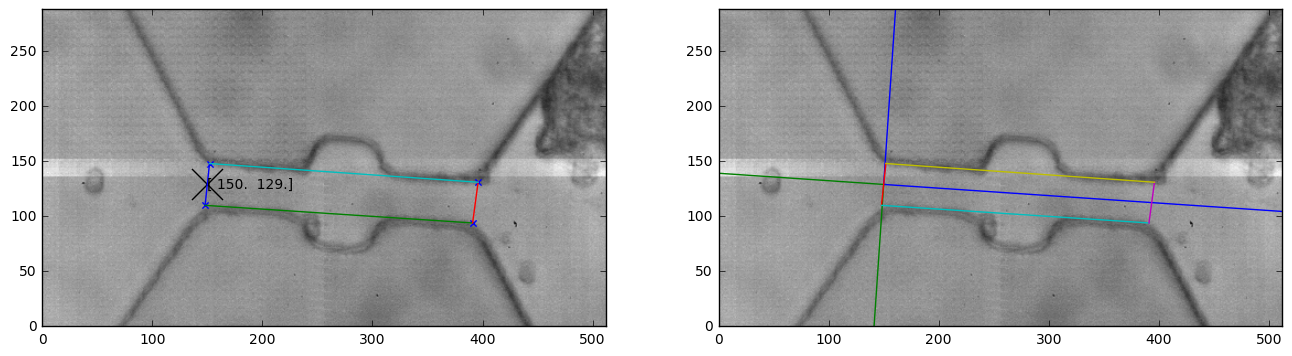

In [21]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [152,148]
c1 = [148,110]
c2 = [391,94]
c3 = [396,131]
stage = oi.Stage(template_frame, c0, c1, c2, c3)
stage._length_microns = 150
stage.plot_stage()

[ 271.75  120.75]
[ 0.99771204 -0.06760677]


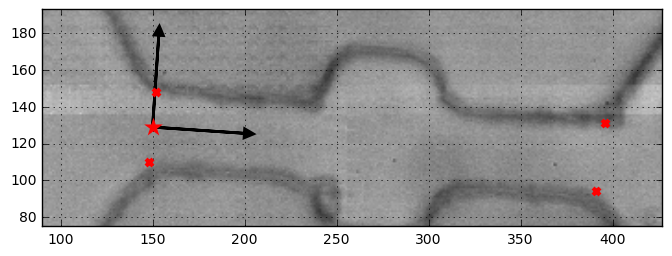

In [22]:
reload(oi)
stage.plot_stage_figure()

##### Get channel enter/exit times

In [23]:
for event in oi_events:
    event.get_channel_enter_exit_tf(stage)

In [24]:
print oi_vid._total_frames

49974


### Filter events (OI)

In [25]:
print len(oi_events)
oi_events = [event for event in oi_events if event._channel_enter_tf != None and event._channel_exit_tf != None]
print len(oi_events)

68
54


##### Sort events

In [26]:
def rp_sort(event):
    return np.mean(event._data[:,0])

def oi_sort(event):
    return (event._channel_enter_tf+event._channel_exit_tf)/2.

rp_events = sorted(rp_events, key = rp_sort)
oi_events = sorted(oi_events, key = oi_sort)

### Video

In [28]:
index = 0
print len(oi_events[index]._detections)
HTML(oi_file.make_animation(oi_vid, oi_events[index]._detections[0]._tf, oi_events[index]._detections[-1]._tf).to_html5_video())

20




### Synchronize events

In [29]:
rp_times = np.array([event._data[:,0].mean() for event in rp_events]).reshape(-1,1)

oi_times = np.array([(event._channel_enter_tf+event._channel_exit_tf)/2./oi_fps for event in oi_events]).reshape(-1,1)

[ 3.19365]


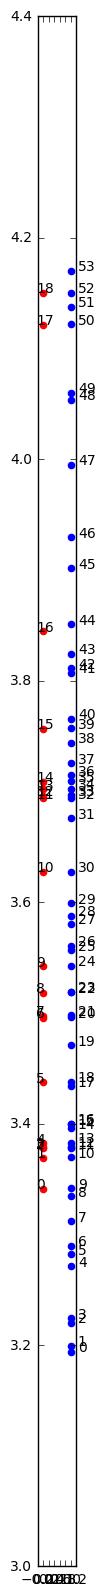

In [31]:
fig = plt.figure(figsize = (.5,20))

offset = rp_times[18]-oi_times[52]

print offset

plt.scatter([0 for i in range(rp_times.shape[0])], rp_times, color = 'red')
plt.scatter([1 for i in range(oi_times.shape[0])], oi_times+offset, color = 'blue')



y_lower = 4.25-oi_fps/oi_vid._total_frames
y_upper = 4.25

for i, event in enumerate(oi_events):
    plt.text(1.25, oi_times[i] + offset, str(i))

for i, event in enumerate(rp_events):
    plt.text(-.25, rp_times[i], str(i))

#plt.ylim(y_lower, y_upper)


plt.show()

##### $\epsilon$ filtering

In [32]:
epsilon_oi_remove_list = []
epsilon_rp_remove_list = []

epsilon = .001
for i, rp_time in enumerate(rp_times):
    diffs = []
    for j, oi_time in enumerate(oi_times):
        diffs.append(np.abs(rp_time - (oi_time + offset)))
        
    if np.min(diffs) >= epsilon:
        epsilon_rp_remove_list.append(i)
        
for i, oi_time in enumerate(oi_times):
    diffs = []
    for j, rp_time in enumerate(rp_times):
        diffs.append(np.abs(rp_time - (oi_time + offset)))
        
    if np.min(diffs) >= epsilon:
        epsilon_oi_remove_list.append(i)
        
print epsilon_rp_remove_list
print epsilon_oi_remove_list

[16]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17, 19, 23, 25, 26, 27, 28, 29, 31, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 53]


##### Remove non-matches

In [33]:
rp_remove_list = epsilon_rp_remove_list + []
oi_remove_list = epsilon_oi_remove_list + []
rp_indices = [i for i in range(len(rp_events)) if i not in rp_remove_list]
oi_indices = [i for i in range(len(oi_events)) if i not in oi_remove_list]

In [34]:
rp_times = np.hstack((np.array([i for i in range(len(rp_events)) if i not in rp_remove_list]).reshape(-1,1),
                      np.array([rp_event._data[:,0].mean() for i, rp_event in enumerate(rp_events)\
                     if i not in rp_remove_list]).reshape(-1,1)))

#oi_times = np.array([(oi_event._channel_enter_tf + oi_event._channel_exit_tf)/(2.*fps) for i, oi_event in enumerate(oi_events)\
#                     if i not in oi_remove_list]).reshape(-1,1)

oi_times = np.hstack((np.array([i for i in range(len(oi_events)) if i not in oi_remove_list]).reshape(-1,1),
                      np.array([(1.*oi_event._channel_enter_tf)/(oi_fps) for i, oi_event in enumerate(oi_events)\
                     if i not in oi_remove_list]).reshape(-1,1)))
                      

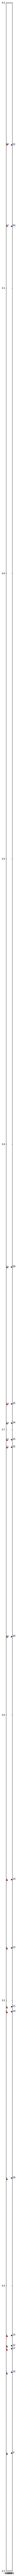

In [35]:
plt.close()
fig = plt.figure(figsize = (.5,200))


plt.scatter([0 for i in range(rp_times.shape[0])], rp_times[:,1], color = 'red')
plt.scatter([1 for i in range(oi_times.shape[0])], oi_times[:,1]+offset[0], color = 'blue')



y_lower = 0
y_upper = 4.25

for i in range(len(rp_times)):
    plt.text(-.25, rp_times[i,1], str(int(rp_times[i,0])))

for i in range(len(oi_times)):
    plt.text(1.25, oi_times[i,1] + offset, str(int(oi_times[i,0])))

    
plt.show()

##### Finally, remove

In [36]:
rp_events = [rp_events[i] for i in range(len(rp_events)) if i not in rp_remove_list]
oi_events = [oi_events[i] for i in range(len(oi_events)) if i not in oi_remove_list]

rp_times = [rp_event._data[:,0].mean() for rp_event in rp_events]
oi_times = [(oi_event._channel_enter_tf + oi_event._channel_exit_tf)/(2.*oi_fps) for oi_event in oi_events]

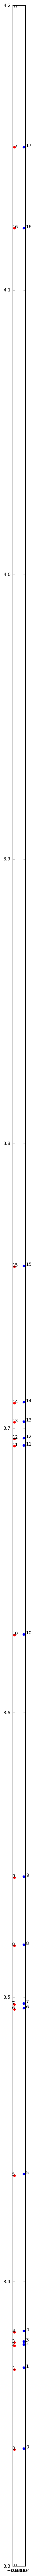

In [37]:
plt.close()
fig = plt.figure(figsize = (.5,100))

offset = rp_times[-1]-oi_times[-1]

plt.scatter([0 for i in range(len(rp_times))], rp_times, color = 'red')
plt.scatter([1 for i in range(len(oi_times))], oi_times+offset, color = 'blue')



y_lower = 0
y_upper = 4.25

for i in range(len(rp_times)):
    plt.text(-.25, rp_times[i], str(i))

for i in range(len(oi_times)):
    plt.text(1.25, oi_times[i] + offset, str(i))

    
plt.show()

##### Save paired events

In [38]:
print len(rp_events), len(oi_events)

rp_events_save_file_path = rp_events_file_path.split('.')[0]+'_sync.json'
oi_events_save_file_path = oi_events_file_path.split('.')[0]+'_sync.json'

print rp_events_save_file_path
print oi_events_save_file_path

18 18
/home/prestonh/Desktop/Research/cancer_cells/data/4-28-2017/PDMS_oil_0/20-50-20_0/rp/events/test_rp_2_events_sync.json
/home/prestonh/Desktop/Research/cancer_cells/data/4-28-2017/PDMS_oil_0/20-50-20_0/oi/events/test_camera_2_events_sync.json


In [39]:
rp_file.save_rp_events_json(rp_events_save_file_path, rp_events)
oi_file.save_oi_events_json(oi_events_save_file_path, oi_events)